In [2]:
import numpy as np
import audioop
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette('mako')

/tmp/ipykernel_64822/1496305103.py:2: DeprecationWarning: 'audioop' is deprecated and slated for removal in Python 3.13
  import audioop


[(0.18195582, 0.11955283, 0.23136943),
 (0.25307401, 0.23772973, 0.48316271),
 (0.21607792, 0.39736958, 0.61948028),
 (0.20344718, 0.56074869, 0.65649508),
 (0.25187832, 0.71827158, 0.67872193),
 (0.54578602, 0.8544913, 0.69848331)]

In [5]:
raw_data = np.fromfile(f'data/raw_data/w0.data', dtype = np.int16)
for i in range(1, 100):
    raw_data = np.append(raw_data, np.fromfile(f'data/raw_data/w{i}.data', dtype = np.int16))

data_iq = raw_data[0::2] + 1j*raw_data[1::2]
signal_real = np.real(data_iq).copy().astype(np.int16) # Add a scaling factor?
signal_real = signal_real.tobytes()

biased = audioop.lin2lin(signal_real, 2, 1)
data = audioop.bias(biased, 1, 2**7)
data = np.frombuffer(data, dtype = np.uint8)

print(data.shape)

(23040000,)


<Axes: ylabel='Count'>

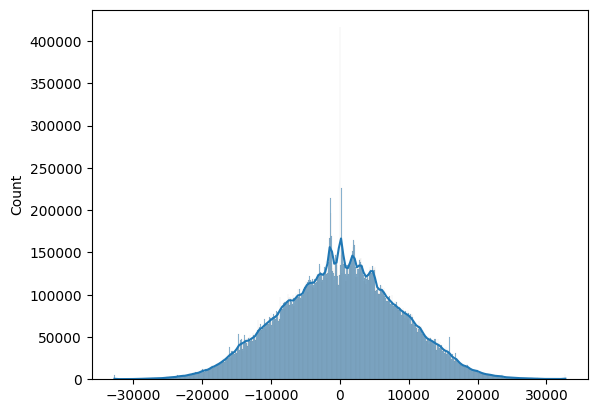

In [ ]:
# Takes 3mins to run
sns.histplot(data, kde = True)

(0.0, 255.0)

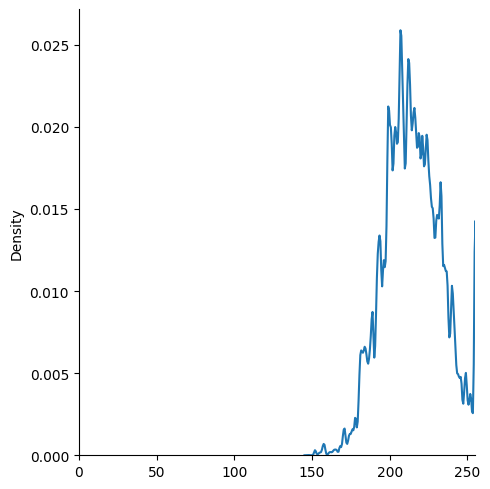

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view
patches = sliding_window_view(data, 256)

sns.displot(np.max(patches, axis = 1), kind = 'kde')
plt.xlim([0,255])

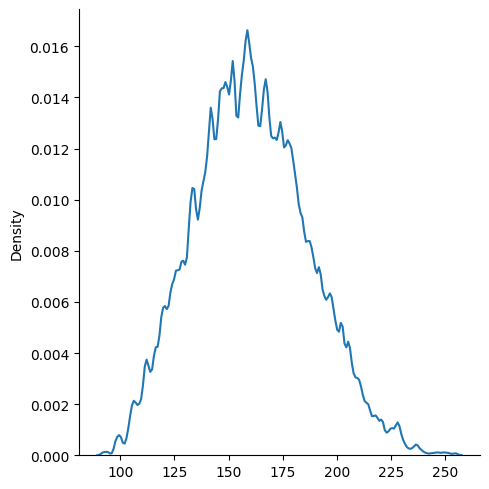

In [7]:
from numpy.lib.stride_tricks import sliding_window_view
patches = sliding_window_view(data, 128)

sns.displot(np.max(patches, axis = 1) - np.min(patches, axis = 1), kind = 'kde')

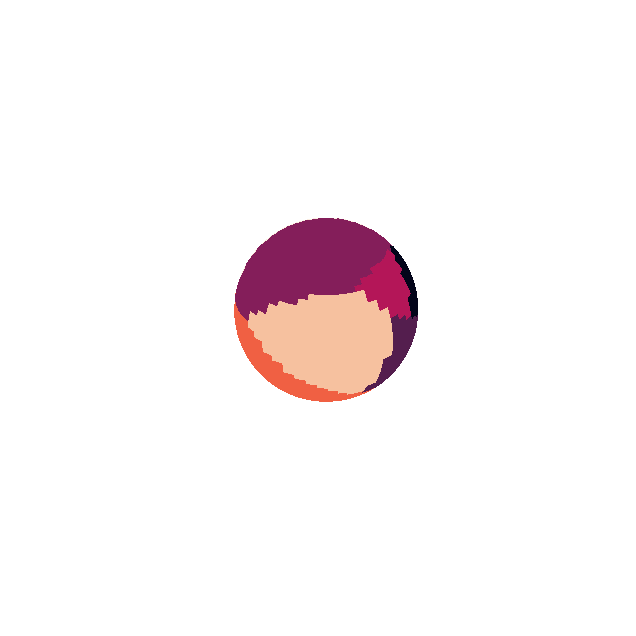

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import cKDTree

# Step 1: Generate the sphere
def generate_sphere(n_points=100):
    u = np.linspace(0, 2 * np.pi, n_points)
    v = np.linspace(0, np.pi, n_points)
    u, v = np.meshgrid(u, v)
    x = np.sin(v) * np.cos(u)
    y = np.sin(v) * np.sin(u)
    z = np.cos(v)
    return x, y, z

# Step 2: Compute distances
def compute_closest_points(sphere_points, data_points):
    # Create a KDTree for fast nearest neighbor search
    tree = cKDTree(data_points)
    distances, indices = tree.query(sphere_points)
    return indices

# Example data points
np.random.seed(0)  # For reproducibility
data_points = np.random.randn(10, 3)
data_points = data_points / np.linalg.norm(data_points, axis=1)[:, np.newaxis]  # Normalize to unit sphere

# Generate sphere points
n_points = 50
x, y, z = generate_sphere(n_points)

# Reshape sphere points into a list of points
sphere_points = np.stack([x.ravel(), y.ravel(), z.ravel()], axis=-1)

# Compute closest points on the sphere
closest_indices = compute_closest_points(sphere_points, data_points)

# Reshape closest_indices to match the shape of x, y, z
closest_indices = closest_indices.reshape(x.shape)

# Normalize the color index to be in the range [0, 1] for colormap
norm = plt.Normalize(0, len(data_points) - 1)
cmap = plt.get_cmap('rocket')

# Create a color array for the surface plot
colors = cmap(norm(closest_indices.ravel())).reshape(x.shape + (4,))  # RGBA

# Plot the sphere
fig = plt.figure(figsize=(10, 8))  # Increase figure size (width, height)
ax = fig.add_subplot(111, projection='3d')

# Plot the sphere surface with colors based on closest point index
surface = ax.plot_surface(x, y, z, facecolors=colors, rstride=1, cstride=1, linewidth=0, antialiased=False, shade=False)

# Remove axes
ax.set_axis_off()

# Set equal scaling
max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
mid_x = (x.max() + x.min()) * 0.5
mid_y = (y.max() + y.min()) * 0.5
mid_z = (z.max() + z.min()) * 0.5
ax.set_xlim([mid_x - max_range, mid_x + max_range])
ax.set_ylim([mid_y - max_range, mid_y + max_range])
ax.set_zlim([mid_z - max_range, mid_z + max_range])

# Set aspect ratio
ax.set_box_aspect([1, 1, 1])  # Aspect ratio is 1:1:1

# Save the figure with higher DPI
plt.savefig('sphere_plot.png', dpi=300, bbox_inches='tight')

plt.show()


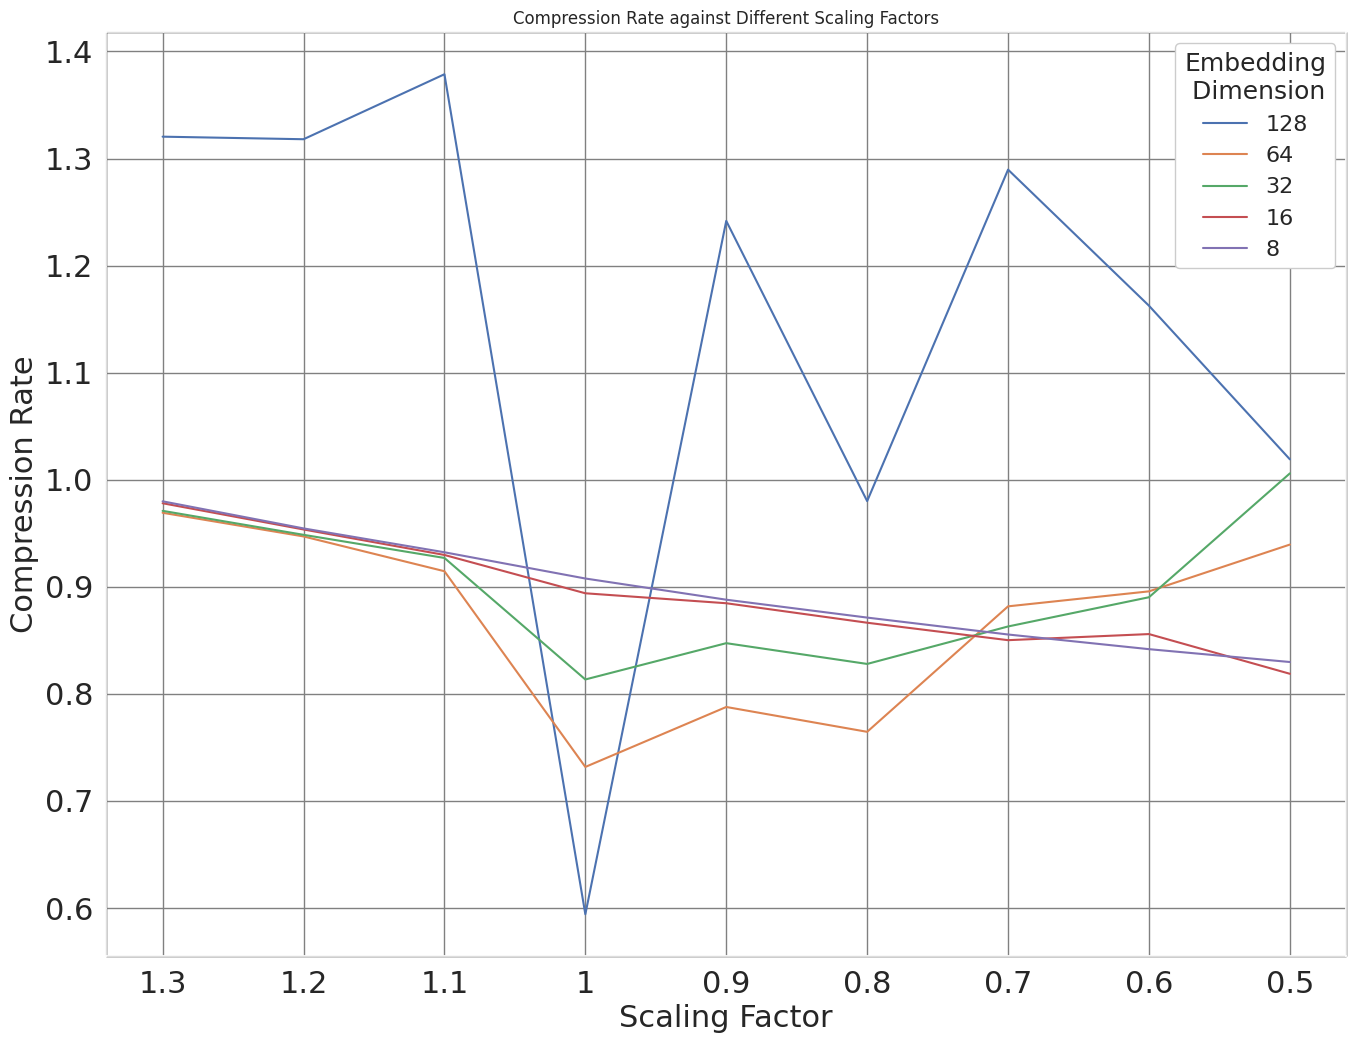

In [34]:
import pandas as pd
import numpy as np
import matplotlib
# Results from embedding test
# Scales were 1.3, 1.2, 1.1, 1, 0.9, 0.8, 0.7, 0.6, 0.5
df = pd.DataFrame(columns = ['e128', 'e64','e32','e16','e8'])
df['e128'] = [1.3204, 1.3180, 1.3787, 0.5941, 1.2417, 0.9800, 1.2896, 1.1625, 1.0190]
df['e64'] = [0.9691, 0.9470, 0.9145, 0.7317, 0.7877, 0.7645, 0.8817, 0.8957, 0.9394]
df['e32'] = [0.9709, 0.9485, 0.9269, 0.8134, 0.8473, 0.8279, 0.8629, 0.8902, 1.0059]
df['e16'] = [0.9780, 0.9535, 0.9297, 0.8939, 0.8846, 0.8664, 0.8501, 0.8558, 0.8187]
df['e8'] = [0.9798, 0.9545, 0.9322, 0.9077, 0.8879, 0.8712, 0.8554, 0.8417, 0.8297]
matplotlib.rcParams.update({'font.size': 33})
xt = [1.3, 1.2, 1.1, 1, 0.9, 0.8, 0.7, 0.6, 0.5]
sns.set_theme()
fig, ax = plt.subplots()
ax.plot(df)
ax.xaxis.set_ticks(np.arange(9), [str(x) for x in xt])
ax.grid(color = 'gray')
ax.set_facecolor('white')
plt.xlabel('Scaling Factor')
fig.set_facecolor('white')
plt.ylabel('Compression Rate')
plt.legend(['128', '64', '32', '16', '8'], title = "Embedding\n Dimension",  frameon= True,facecolor = 'white', framealpha=1, fontsize=16, 
           title_fontsize=18)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(22)
fig.set_figwidth(16)
fig.set_figheight(12)
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(1)  
plt.title('Compression Rate against Different Scaling Factors')
plt.savefig('figs/emb_expr/real_vals.eps', format = 'eps', dpi=1200)
plt.show()

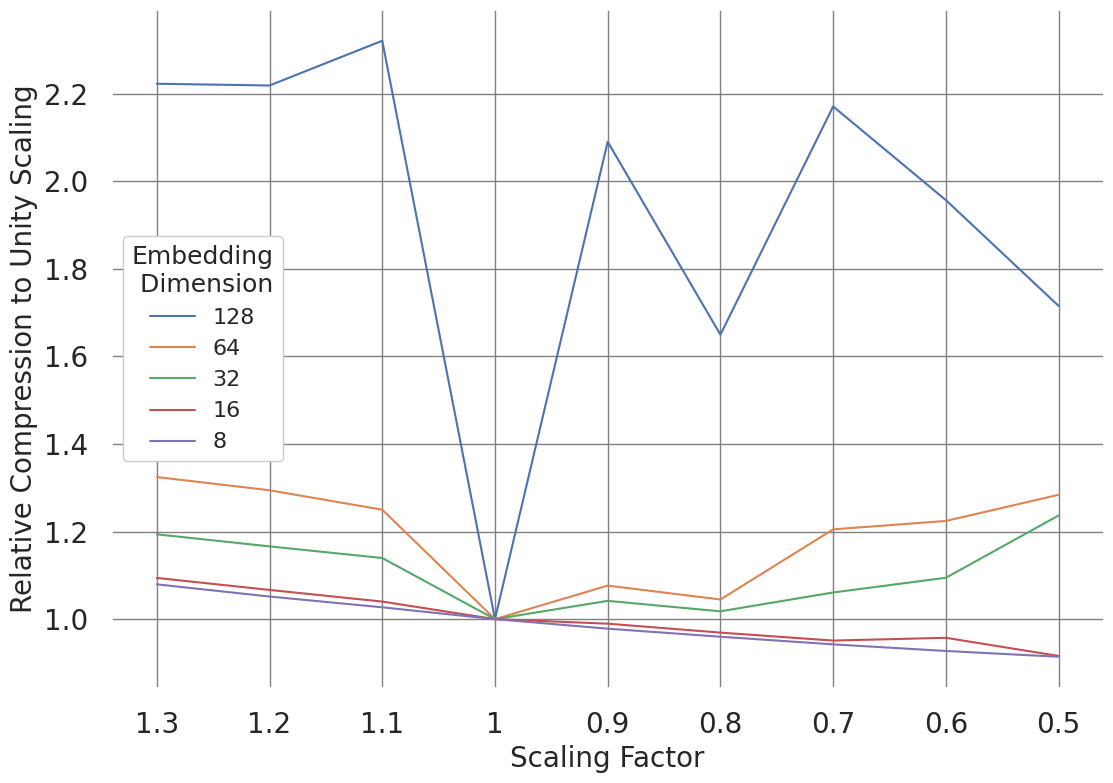

In [79]:
import pandas as pd
import numpy as np
import matplotlib
# Results from embedding test
# Scales were 1.3, 1.2, 1.1, 1, 0.9, 0.8, 0.7, 0.6, 0.5

df = pd.DataFrame(columns = ['e128', 'e64','e32','e16','e8'])
df['e128'] = [1.3204, 1.3180, 1.3787, 0.5941, 1.2417, 0.9800, 1.2896, 1.1625, 1.0190]
df['e64'] = [0.9691, 0.9470, 0.9145, 0.7317, 0.7877, 0.7645, 0.8817, 0.8957, 0.9394]
df['e32'] = [0.9709, 0.9485, 0.9269, 0.8134, 0.8473, 0.8279, 0.8629, 0.8902, 1.0059]
df['e16'] = [0.9780, 0.9535, 0.9297, 0.8939, 0.8846, 0.8664, 0.8501, 0.8558, 0.8187]
df['e8'] = [0.9798, 0.9545, 0.9322, 0.9077, 0.8879, 0.8712, 0.8554, 0.8417, 0.8297]
matplotlib.rcParams.update({'font.size': 33})

xt = [1.3, 1.2, 1.1, 1, 0.9, 0.8, 0.7, 0.6, 0.5]
sns.set_theme()
fig, ax = plt.subplots()
ax.plot(df/df.iloc[3,:])
ax.xaxis.set_ticks(np.arange(9), [str(x) for x in xt])
ax.grid(color = 'gray')
ax.set_facecolor('white')
plt.xlabel('Scaling Factor')
fig.set_facecolor('white')
plt.ylabel('Relative Compression to Unity Scaling')
plt.legend(['128', '64', '32', '16', '8'], title = "Embedding\n Dimension",  frameon= True,facecolor = 'white', framealpha=1, fontsize=16, 
           title_fontsize=18)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.savefig('figs/emb_expr/relative_embedding.eps', format = 'eps', dpi=1200)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


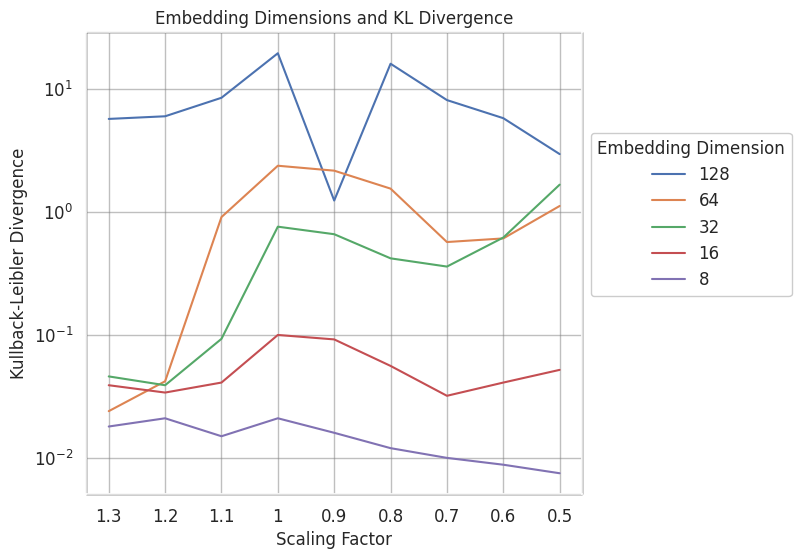

In [29]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Results from embedding test
# Scales were 1.3, 1.2, 1.1, 1, 0.9, 0.8, 0.7, 0.6, 0.5

df = pd.DataFrame(columns = ['e128', 'e64','e32','e16','e8'])
df['e128'] = [5.72, 6.01, 8.50, 19.57, 1.24, 16.08, 8.14, 5.80, 2.96]
df['e64'] = [0.024, 0.042, 0.91, 2.38, 2.17, 1.55, 0.57, 0.61, 1.12]
df['e32'] = [0.046, 0.039, 0.093, 0.76, 0.66, 0.42, 0.36, 0.62, 1.67]
df['e16'] = [0.039, 0.034, 0.041, 0.10, 0.092, 0.056, 0.032, 0.041, 0.052]
df['e8'] = [0.018, 0.021, 0.015, 0.021, 0.016, 0.012, 0.010, 0.0088, 0.0075]
matplotlib.rcParams.update({'font.size': 33})

xt = [1.3, 1.2, 1.1, 1, 0.9, 0.8, 0.7, 0.6, 0.5]
sns.set_theme()
fig, ax = plt.subplots()
ax.plot(df)
ax.xaxis.set_ticks(np.arange(9), [str(x) for x in xt])
ax.grid(color = 'gray', alpha = 0.5, linestyle = '-')
ax.set_facecolor('white')
plt.xlabel('Scaling Factor')
fig.set_facecolor('white')
plt.ylabel('Kullback-Leibler Divergence')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(1)  
ax.set_yscale('log')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(['128', '64', '32', '16', '8'], title = "Embedding Dimension",  frameon= True,facecolor = 'white', framealpha=1, fontsize=12, 
           title_fontsize=12, bbox_to_anchor=(1, 0.8))
plt.title('Embedding Dimensions and KL Divergence')
fig.set_figwidth(8)
fig.set_figheight(6)
plt.savefig('figs/emb_expr/klds.eps', format = 'eps', dpi=1200)
plt.show()

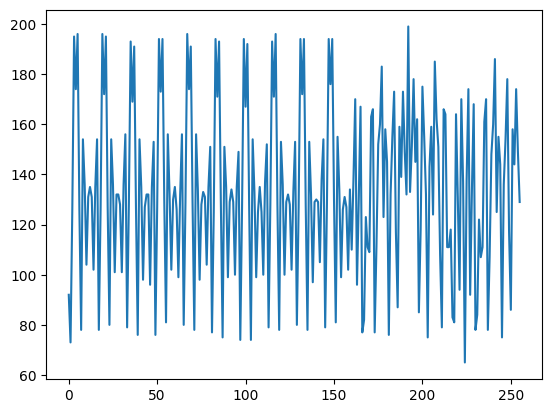

In [13]:
raw_data = np.fromfile(f'data/raw_data/w0.data', dtype = np.int16)

data_iq = raw_data[0::2] + 1j*raw_data[1::2]
signal_real = np.real(data_iq).copy().astype(np.int16) # Add a scaling factor?
signal_real = signal_real.tobytes()

biased = audioop.lin2lin(signal_real, 2, 1)
data = audioop.bias(biased, 1, 2**7)
data = np.frombuffer(data, dtype = np.uint8)

noisy = data[0:256] + np.random.normal(0,2,data[0:256].size)
#plt.plot(data[0:256])
plt.plot(noisy.astype(np.uint8))

In [21]:
d = np.array([data[0:256], data[256:256*2]])
d.shape
r = np.random.normal(0,2,d.shape)
r.shape
d + r

array([[ 95.16409422,  79.9502085 , 125.96349275, 195.19854658,
        172.69892056, 195.23657001, 129.57495324,  73.05501176,
        153.97570605, 134.10839752, 100.86004208, 127.04464697,
        136.33017346, 126.90930711, 100.74520155, 136.12870024,
        154.1559395 ,  80.80775293, 130.94025035, 195.04116944,
        172.94747134, 194.39600369, 127.51071735,  76.50724628,
        152.37180119, 136.99145403,  97.3470058 , 130.78602749,
        137.66832786, 130.10109934, 101.19370038, 134.43449106,
        159.39497821,  75.09330186, 131.02301808, 193.2002474 ,
        175.36611026, 194.67038659, 132.21015534,  76.84553395,
        151.05695392, 133.06386208, 101.41350996, 128.4368681 ,
        128.10951122, 126.67810759, 102.1699809 , 134.23599482,
        157.60214088,  78.28398765, 129.24951878, 198.06885169,
        173.18374294, 194.80548032, 131.09206874,  75.44888717,
        151.81215882, 133.75439155, 102.56032919, 128.0109741 ,
        134.56522179, 128.56337846,  99.

In [3]:
def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    import matplotlib.pyplot as plt
    cutoff = 32
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train[-cutoff:])
    #plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    #plt.plot(pred, 'ro', label=model_name, color='purple')
    plt.plot(pred,  label=model_name, color='purple')
    #plt.plot(train.tail(1), 'ro', color='black')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()
    plt.savefig('foo.png')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 1/1 [00:18<00:00, 18.86s/it]


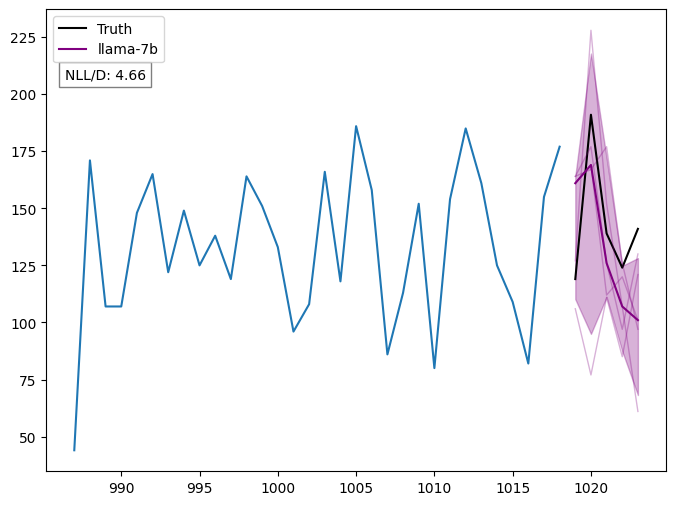

<Figure size 640x480 with 0 Axes>

In [14]:
# Here we try implement Llama
%load_ext autoreload
%autoreload 2
import llama.llama as llama
import llama.llmtime as llmtime
from llama.serialize import SerializerSettings
import numpy as np
import pandas as pd
import audioop
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette('mako')

llma2_hypers = dict(
    model = 'llama-7b',
    temp=1, 
    alpha=0,
    beta=0, # These are just shift parameters and don't matter
    basic=False,
    settings=SerializerSettings(base=10, prec=0, signed=True, half_bin_correction=False, time_sep=',', bit_sep = '', max_val = 255) 
)

data=np.fromfile('data/test/w_test.data',np.int16)
data_iq = data[0::2] + 1j*data[1::2]
signal_real = np.real(data_iq).copy().astype(np.int16)
signal_real = signal_real.tobytes()
new_signal = audioop.lin2lin(signal_real, 2, 1)
new_signal = audioop.bias(new_signal, 1, 2**7)
signal = np.frombuffer(new_signal, dtype=np.uint8)

CW = 1024
tk_jp = 5 # temp measure
offset = 400
split = 0.8
signal_cut = signal[offset:offset + CW]
data = pd.Series(signal_cut.astype(np.float32))
#train = data[0:int(split*CW)]
train = data[0:CW-tk_jp]
#test = data[int(split*CW):CW]
test = data[CW - tk_jp:CW]


pred_dict = llmtime.get_llmtime_predictions_data(
    train = [train],
    test = [test],
    **llma2_hypers,
    num_samples = 5,
    parallel = True,
)
plot_preds(data[0:CW-tk_jp], test, pred_dict, 'llama-7b', show_samples=True)


In [2]:
# Now we have a way to get the predictions, how can we 
# make a measure of its confidence?

from transformers import LlamaForCausalLM, LlamaTokenizer
import pandas as pd
d = pd.read_pickle(r'generate_ids.data')
tokenizer = LlamaTokenizer.from_pretrained(
    'meta-llama/Llama-2-7b-hf',
    use_fast = False
)

/home/mattf/anaconda3/envs/llmcomp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['']


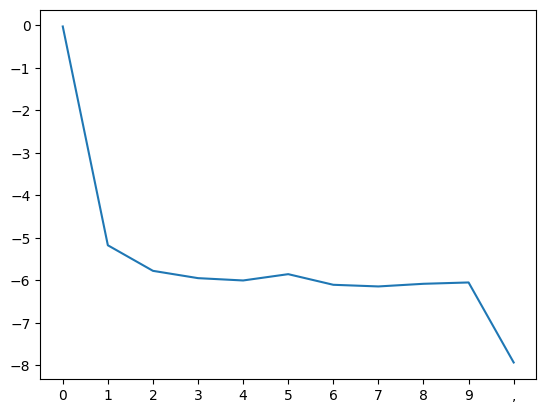

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
print(tokenizer.batch_decode(d[0][:,491: ]))

# 1 (and first) is 29896

good_tokens_str = list("0123456789,")
good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
ft = d[1][2][:, good_tokens][0]
plt.plot(ft.cpu())
plt.xticks(range(11),[str(x) for x in np.arange(10)] + [','])
plt.show()



0.9996948242187501

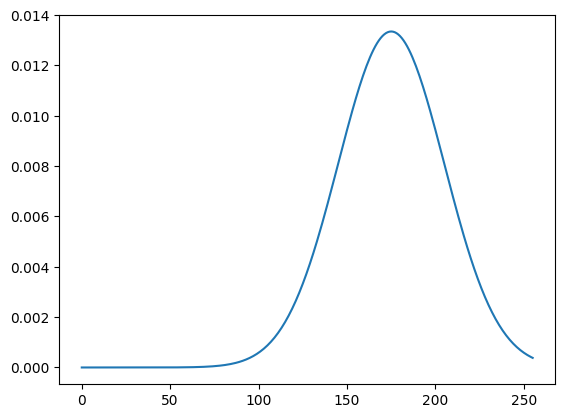

: 

In [19]:
import scipy.stats as stats
import utils

loc = 175
scale = 30
a_trunc = 0
b_trunc = 255
a, b = (a_trunc - loc) / scale, (b_trunc - loc) / scale
x = np.arange(256)
plt.plot(x, stats.truncnorm.pdf(x, a, b, loc, scale))

sum(utils.normalize_pdf_for_arithmetic_coding(stats.cauchy.pdf(x, loc, scale)))

In [1]:
# We need to experiment if this can be parallelised otherwise it is going to be 
# Very slow

import scipy.stats as stats
import utils
import torch
import numpy as np
import matplotlib.pyplot as plt
import llama.llama as llama
import llama.llmtime as llmtime
from llama.serialize import SerializerSettings
import numpy as np
import pandas as pd
import audioop
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
llma2_hypers = dict(
    model = 'llama-7b',
    temp=1, 
    alpha=0,
    beta=0, # These are just shift parameters and don't matter
    basic=False,
    settings=SerializerSettings(base=10, prec=0, signed=True, half_bin_correction=False, time_sep=',', bit_sep = '', max_val = 255) 
)

#train = np.array([[0,1,0,1,0], [1,0,1,0,1]]).astype(np.float32)
#test = np.array([[1], [0]]).astype(np.float32)

train = [np.array([0.,1.,0.,1.,0.]), np.array([1.,0.,1.,0.,1])]
test = [np.array([1.]), np.array([0.])]

pred_dict = llmtime.get_llmtime_predictions_data(
    train = train,
    test = test,
    **llma2_hypers,
    num_samples = 5,
    parallel = True,
)

/home/mattf/anaconda3/envs/llmcomp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_22456/2713443570.py:14: DeprecationWarning: 'audioop' is deprecated and slated for removal in Python 3.13
  import audioop


Running completions in parallel for each input


  0%|          | 0/2 [00:00<?, ?it/s]



Loading checkpoint shards: 100%|██████████| 3/3 [00:10<00:00,  3.47s/it]

Loading checkpoint shards: 100%|██████████| 3/3 [00:10<00:00,  3.59s/it]
2024-09-18 14:27:51.182728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 14:27:51.204167: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 14:27:51.210673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.

Setting `pad_token_id` to `eos_token_id`

In [5]:
pred_dict['samples'][1]

,5
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [4]:
# Get pdf of training
raw_data = np.fromfile(f'data/raw_data/w0.data', dtype = np.int16)
for i in range(1, 100):
    raw_data = np.append(raw_data, np.fromfile(f'data/raw_data/w{i}.data', dtype = np.int16))

data_iq = raw_data[0::2] + 1j*raw_data[1::2]
signal_real = np.real(data_iq).copy().astype(np.int16) # Add a scaling factor?
signal_real = signal_real.tobytes()

biased = audioop.lin2lin(signal_real, 2, 1)
data = audioop.bias(biased, 1, 2**7)
data = np.frombuffer(data, dtype = np.uint8)

hist = np.histogram(data, bins = 128)

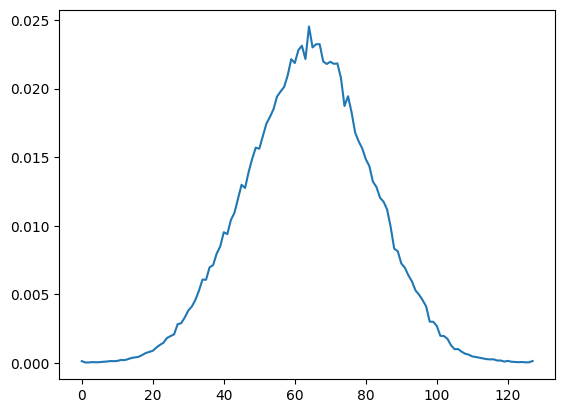

In [13]:
import pickle
import utils
plt.plot(utils.normalize_pdf_for_arithmetic_coding(hist[0]))

dist = utils.normalize_pdf_for_arithmetic_coding(hist[0])

with open('hist.pkl', 'wb') as f:
    pickle.dump(dist, f)

In [16]:
with open('hist.pkl', 'rb') as f:
    test = pickle.load(f)

test

array([1.24635312e-04, 2.65749693e-05, 2.83973296e-05, 5.55591769e-05,
       4.17179161e-05, 4.84866831e-05, 7.62993733e-05, 9.50436513e-05,
       1.27932917e-04, 1.23116679e-04, 1.39517922e-04, 2.06120854e-04,
       1.95837535e-04, 2.66649252e-04, 3.55337456e-04, 3.96644290e-04,
       4.39990433e-04, 5.66991594e-04, 7.13431266e-04, 7.92920889e-04,
       8.79786732e-04, 1.11109633e-03, 1.30513432e-03, 1.46311560e-03,
       1.81075254e-03, 1.94981599e-03, 2.07616631e-03, 2.81608800e-03,
       2.89154240e-03, 3.29918705e-03, 3.81339640e-03, 4.10480050e-03,
       4.58998225e-03, 5.25583801e-03, 6.06895785e-03, 6.05719928e-03,
       6.96204459e-03, 7.13143733e-03, 7.96724989e-03, 8.48822800e-03,
       9.52246089e-03, 9.38591403e-03, 1.04171530e-02, 1.09357881e-02,
       1.19597377e-02, 1.29822988e-02, 1.27509458e-02, 1.39194259e-02,
       1.48762953e-02, 1.56888944e-02, 1.56125723e-02, 1.65181986e-02,
       1.74427427e-02, 1.79257984e-02, 1.84929430e-02, 1.94164458e-02,
      

In [352]:
# LLama character-based compression

from transformers import LlamaForCausalLM, LlamaTokenizer, GenerationConfig
import pandas as pd
import numpy as np
import utils
import audioop

tokenizer = LlamaTokenizer.from_pretrained(
    'meta-llama/Llama-2-7b-hf',
    use_fast = False,
    padding=True,
)
model = LlamaForCausalLM.from_pretrained('meta-llama/Llama-2-7b-hf')

Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


In [14]:
raw_data = np.fromfile(f'data/test/w_test.data', dtype = np.int16)
data_iq = raw_data[0::2] + 1j*raw_data[1::2]
signal_real = np.real(data_iq).copy().astype(np.int16) 
signal_real = signal_real.tobytes()
biased = audioop.lin2lin(signal_real, 2, 1)
data = audioop.bias(biased, 1, 2**7)
ndata = np.frombuffer(data, dtype = np.uint8)
data = np.right_shift(ndata, 1)

In [335]:
import matplotlib.pyplot as plt

offset = 0
size = 128
cdata = data[offset:size+offset]
fulldata = data[offset:size+offset+16]
tk = tokenizer(cdata.tobytes().decode('ascii'))['input_ids']


In [345]:
import torch
def evaluate(instruction):
    generation_config = GenerationConfig(
    temperature=0.2,
    #top_p= 0.75,
    top_k = 100,
    num_beams=1,
    do_sample = True,
    )
    
    prompt = instruction
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]

    generation_output = model.generate(
        **inputs,
        generation_config=generation_config,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=16,
    )
    return generation_output

#rp = evaluate(cdata.tobytes().decode('ascii'))
testrp = evaluate(['This is the record', 'This is the record of', 'This is the record of John'])

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`input_ids` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

In [355]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.batch_encode_plus(['This is the record', 'This is the record of', 'This is the record of John'], return_tensors='pt', padding = True)

{'input_ids': tensor([[   1,  910,  338,  278, 2407,    2,    2],
        [   1,  910,  338,  278, 2407,  310,    2],
        [   1,  910,  338,  278, 2407,  310, 2259]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1]])}

[42 35 62 97 86 97 62 35 76 66 47 62 65 62 47 66 76 35 62 97 86 97 62 35
 76 66 47 62 65 62 47 66 76 35 62 97 86 97 62 35 76 66 47 62 65 62 47 66
 76 35 62 97 86 97 62 35 76 66 47 62 65 62 47 66 76 35 62 97 86 97 62 35
 76 66 47 62 65 62 47 66 76 35 62 97 86 97 62 35 76 66 47 62 65 62 47 66
 76 35 62 97 86 97 62 35 76 66 47 62 65 62 47 66 76 35 62 97 86 97 62 35
 76 66 47 62 65 62 47 66]
[60, 115, 62, 42, 35, 62, 97, 86, 97, 62, 35, 76, 66, 47, 62, 65, 62, 47, 66, 76, 35, 62, 97, 86, 97, 62, 35, 76, 66, 47, 62, 65, 62, 47, 66, 76, 35, 62, 97, 86, 97, 62, 35, 76, 66, 47, 62, 65, 62, 47, 66, 76, 35, 62, 97, 86, 97, 62, 35, 76, 66, 47, 62, 65, 62, 47, 66, 76, 35, 62, 97, 86, 97, 62, 35, 76, 66, 47, 62, 65, 62, 47, 66, 76, 35, 62, 97, 86, 97, 62, 35, 76, 66, 47, 62, 65, 62, 47, 66, 76, 35, 62, 97, 86, 97, 62, 35, 76, 66, 47, 62, 65, 62, 47, 66, 76, 35, 62, 97, 86, 97, 62, 35, 76, 66, 47, 62, 65, 62, 47, 66, 35, 62, 97, 86, 97, 62, 35, 76, 66, 47, 62, 65, 62, 47, 66, 76, 35, 62, 97]


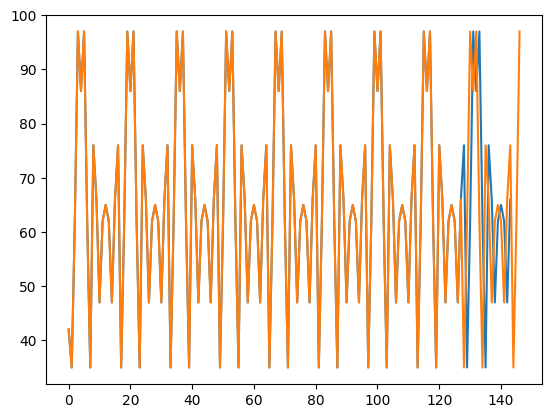

In [340]:
input_tokens = cdata
output_tokens_ascii = [ord(x) for x in tokenizer.decode(rp['sequences'][0])]

print(input_tokens)
print(output_tokens_ascii)

graph_offset = 0
plt.plot(fulldata[graph_offset:])
plt.plot(output_tokens_ascii[3+graph_offset:])
plt.show()
#plt.plot(np.arange(64, 64+len(tp)),tp)


In [417]:
#pdf = utils.normalize_pdf_for_arithmetic_coding(rp['scores'][0].sort()[0][0])
pdf = np.array((utils.normalize_pdf_for_arithmetic_coding(np.exp(torch.nan_to_num(rp['scores'][0].sort()[0][0])))))
#print(pdf)
output = list()
import arithmetic_coder
encoder = arithmetic_coder.Encoder(
    base=2,
    precision=32,
    output_fn=output.append,
)
encoder.encode(utils.normalize_pdf_for_arithmetic_coding(pdf), 31991)
compressed_bits = ''.join(map(str, output))
compressed_bits

'000100110010011'

In [343]:
len(rp['scores'])

16

In [255]:
print(rp['scores'][0].sort()[0][0][-100:])
print(r['scores'][0].sort()[1][0][-100:])
print([tokenizer.decode(x)for x in rp['scores'][0].sort()[1][0][-100:]])

tensor([4.2847, 4.3068, 4.3327, 4.3561, 4.3798, 4.4453, 4.4759, 4.5302, 4.5465,
        4.5587, 4.6001, 4.6172, 4.6296, 4.6394, 4.6518, 4.6553, 4.7146, 4.7155,
        4.7302, 4.7462, 4.7465, 4.7710, 4.8206, 4.8267, 4.8391, 4.8421, 4.8438,
        4.8544, 4.8566, 4.8608, 4.8626, 4.8771, 4.8852, 4.9654, 4.9893, 5.0305,
        5.0594, 5.0950, 5.1392, 5.1520, 5.1824, 5.2499, 5.2501, 5.2571, 5.2823,
        5.3019, 5.3467, 5.3513, 5.3997, 5.4246, 5.5282, 5.5692, 5.5933, 5.5959,
        5.6572, 5.6981, 5.7583, 5.8163, 5.8414, 5.8536, 5.8958, 5.9298, 5.9530,
        6.0196, 6.0296, 6.0305, 6.0449, 6.0615, 6.0655, 6.0979, 6.1087, 6.1198,
        6.1932, 6.2152, 6.2653, 6.2956, 6.3005, 6.3018, 6.3211, 6.5470, 6.6858,
        6.8172, 6.8745, 6.9439, 7.0063, 7.0504, 7.0630, 7.2041, 7.2296, 7.2343,
        7.3807, 7.4432, 7.6034, 7.6168, 7.9631, 7.9712, 8.4464, 8.8672, 8.9230,
        9.0419])
tensor([    4, 29891, 29925, 29884, 29913, 29918, 30022,    31,    17,    22,
        12222, 29912, 299

In [243]:
# Try convert to distribution 
dist = {}
for i in range(100):
    try:
        v = ord(tokenizer.decode(rp['scores'][0].sort()[1][0][-100:][i]))
        if v > 128:
            continue
        dist[v] = float(rp['scores'][0].sort()[0][0][-100:][i])
    except:
        continue



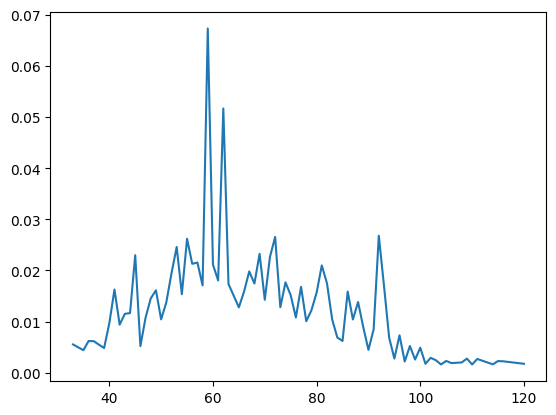

In [244]:
lists = sorted(dist.items())
x, y = zip(*lists)
y = utils.normalize_pdf_for_arithmetic_coding(np.exp(y))
plt.plot(x, y)
plt.show()

In [227]:
print(*dist)

121 80 117 125 95 126 123 113 120 101 115 82 114 34 77 111 107 46 103 106 119 76 108 33 85 39 42 47 104 38 102 99 43 90 100 116 105 97 91 35 109 44 40 41 79 94 71 93 87 36 92 45 51 89 49 75 61 50 74 88 65 96 48 72 58 86 54 57 81 66 55 37 98 67 52 62 63 68 53 60 64 70 56 59


In [13]:
import matplotlib.pyplot as plt
import numpy as np


with np.load(f'data/chunked_data/c256/data0.npz', allow_pickle=True) as f:
        d = f['dat'].astype(np.uint8)

for i in range(1,10):
    print(i)
    with np.load(f'data/chunked_data/c256/data{i}.npz', allow_pickle=True) as f:
        d = np.append([d], [f['dat'].astype(np.uint8)])

#return map(lambda x: x.tobytes(), d.astype(np.uint8))
d

1
2
3
4
5
6
7
8
9


array([ 48,  19, 117, ..., 137, 208, 141], dtype=uint8)

In [20]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

x = np.arange(128)
pdf = scipy.stats.norm(x, 60, 1)
plt.plot(pdf)

TypeError: _parse_args() takes from 1 to 3 positional arguments but 4 were given

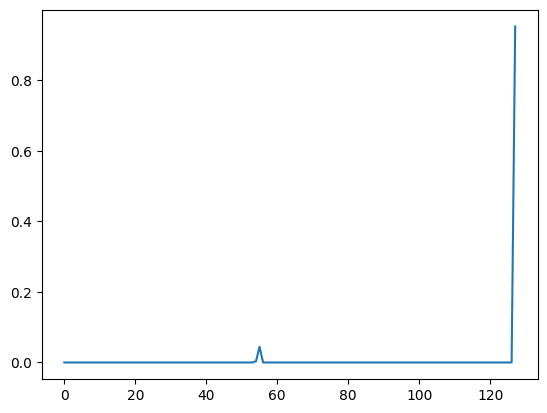